In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pykalman import KalmanFilter
from keras.layers import Dense, LSTM, Dropout, Input, Flatten, RepeatVector, Permute, multiply, Lambda, Activation, Conv1D, MaxPooling1D, Bidirectional
from keras.models import Model
# from keras import backend as K
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Function to apply Kalman filter
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
    (filtered_state_means, _) = kf.filter(data)
    return filtered_state_means

In [ ]:
def create_attention_model_LSTM(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # LSTM layer
    lstm_out = LSTM(units, return_sequences=True)(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)  # Adjusted input shape to match the output shape of LSTM
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([lstm_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model

# Function to create BiLSTM model with attention mechanism
def create_attention_model_BiLSTM(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # BiLSTM layer
    lstm_out = Bidirectional(LSTM(units, return_sequences=True))(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(2 * units)(attention)  # Adjusted input shape to match the output shape of BiLSTM
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([lstm_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1),)(sent_representation)

    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model


def create_attention_model_GRU(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # GRU layer
    gru_out = GRU(units, return_sequences=True)(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(gru_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)  # Adjusted input shape to match the output shape of GRU
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([gru_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:

# Define folder path containing the dataset files
folder_path = '/content/drive/MyDrive/dataset/planetlabs_subset_data_demo'

# Initialize lists to store MAE and MSE for each file
mae_list = []
mse_list = []

# Initialize the model
window_size = 10  # Define window size
train_ratio = 0.4  # Define train ratio
validation_ratio = 0.2  # Define validation ratio
attention_model = create_attention_model_BiLSTM(input_shape=(window_size, 1), units=50)
attention_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [ ]:

# Iterate over each file
for file_name in file_list:
    # Read data from the file
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, header=None)

    # Apply Kalman filter
    df['cpu_filtered'] = apply_kalman_filter(df[0])

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['cpu_scaled'] = scaler.fit_transform(df['cpu_filtered'].values.reshape(-1, 1))

    # Create dataset
    data = df['cpu_scaled'].values
    dataX, dataY = [], []
    for i in range(len(data)-window_size-1):
        a = data[i:(i+window_size)]
        dataX.append(a)
        dataY.append(data[i + window_size])
    X = np.array(dataX)
    y = np.array(dataY)

    # Split data into train and validation sets
    train_size = int(len(X) * train_ratio)
    validation_size = int(len(X) * validation_ratio)
    test_size = len(X) - train_size - validation_size
    X_train, y_train = X[:train_size], y[:train_size]
    X_validation, y_validation = X[train_size:train_size+validation_size], y[train_size:train_size+validation_size]
    X_test, y_test = X[train_size+validation_size:], y[train_size+validation_size:]  # Separate test data

    # Train the model
    history = attention_model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                                  epochs=100, batch_size=16, verbose=1)

    # Evaluate the model on the validation dataset
    score = attention_model.evaluate(X_test, y_test, verbose=0)
    mae_list.append(score[2])  # Append MAE to the list
    mse_list.append(score[1])  # Append MSE to the list

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - loss: 0.1881 - mae: 0.3677 - mse: 0.1881 - val_loss: 0.1126 - val_mae: 0.2707 - val_mse: 0.1126
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0919 - mae: 0.2503 - mse: 0.0919 - val_loss: 0.0667 - val_mae: 0.2224 - val_mse: 0.0667
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0718 - mae: 0.2163 - mse: 0.0718 - val_loss: 0.0737 - val_mae: 0.2244 - val_mse: 0.0737
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0723 - mae: 0.2162 - mse: 0.0723 - val_loss: 0.0665 - val_mae: 0.2241 - val_mse: 0.0665
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0658 - mae: 0.2110 - mse: 0.0658 - val_loss: 0.0685 - val_mae: 0.2298 - val_mse: 0.0685
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0651 - mae: 0.2185 - mse: 0.0651 - val_loss: 0.0678 - val_mae: 0.2288 - val_mse: 0.0678
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0640 - mae: 0.2049 - mse: 0.0640 - val_loss: 0.0662

In [ ]:
# Calculate final MAE and MSE on test data
final_mae = np.mean(mae_list)
final_mse = np.mean(mse_list)

print("Test MAE:", final_mae)
print("Test MSE:", final_mse)

Test MAE: 0.10848411303013564
Test MSE: 0.02522819018922746


In [ ]:
# Define folder path to save the model
model_save_folder = '/content/drive/MyDrive/trained_models/'

# Define file path to save the model
model_save_path = os.path.join(model_save_folder, 'planetLabs_BiLSTM_w10.h5')

# Save the model
attention_model.save(model_save_path)

print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/trained_models/planetLabs_BiLSTM_w10.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


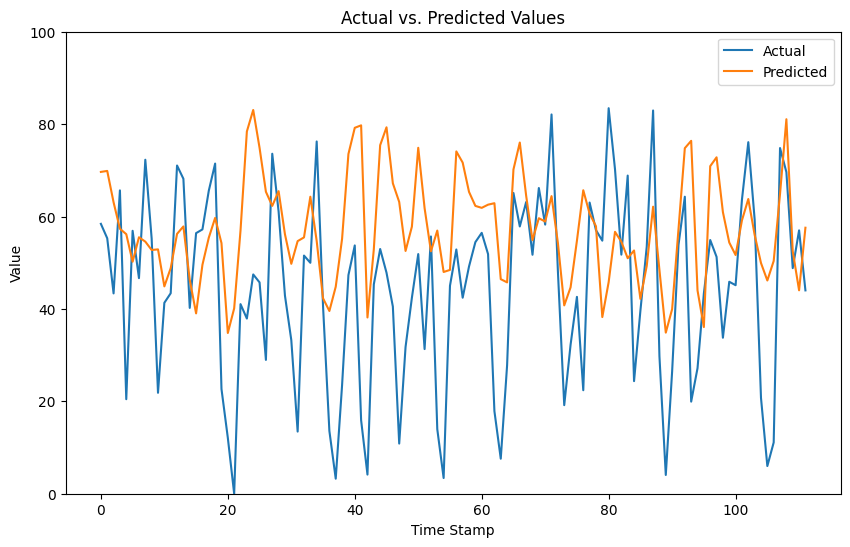

In [ ]:
# Make predictions on the test data
predictions = attention_model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test * 100, label='Actual')  # Scale actual values to 0-100
plt.plot(predictions * 100, label='Predicted')  # Scale predicted values to 0-100
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Stamp')
plt.ylabel('Value')
plt.ylim(0, 100)  # Set y-axis limits to 0-100
plt.legend()
plt.show()
